## FC for Widespread Pain Subjects
#### Input: *stc.mat
####  Output: con, visualization

In [1]:
import os
from pathlib import Path
import sys
import mne 
from mne.datasets import fetch_fsaverage
fs_dir = fetch_fsaverage(verbose=True)
subject = "fsaverage"
subjects_dir = os.path.dirname(fs_dir)
sys.path.append("/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/")
from eeg_toolkit import preprocess, utils
import eeg_toolkit.functional_connectivity as fc

0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage


In [2]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / "Source Time Courses"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Widespread_Pain"
fc_path = data_dir / "Functional Connectivity"
fc_subset_path = fc_path / subset
save_path = fc_subset_path

os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


### Get CLBP WSP from viable subject IDs

In [3]:
# viable subjects
sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
sub_ids = sub_ids[7:]  # select only 64ch subs and turn into set
sub_ids_CP_WSP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

# CP Subs with widespread pain
widespread_pain_CP = [
    '055',
    '052',
    '046',
    '039',
    '036',
    '031',
    '022',
    '045',
    '040',
    '034',
    '032',
    '024',
    '018'
]

# Sort and limit CP subs to only those with widespread pain
widespread_pain_CP.sort()
sub_ids_CP_WSP = widespread_pain_CP

# Exclude HEALTHY subjects with widespread pain
widespread_pain_HC = ['C1.','C23']
sub_ids_HC = [sub for sub in sub_ids_HC if sub not in widespread_pain_HC]

# Combine selected CP and HC subjects
sub_ids = sub_ids_CP_WSP + sub_ids_HC

# Exclude subjects with NaN source localization
NAN_SUBS = ['018','021','C1.','C2.','C3.']
sub_ids = [sub for sub in sub_ids if sub not in NAN_SUBS]

exclude_resting=True

# These subjects have no keypresses and thus no resting timestamps, but they do have epoched data
# TODO: estimate eyes open timestamps from alpha band power
NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']
sub_ids = [sub for sub in sub_ids if sub not in NO_KEYPRESS]

In [4]:
sub_ids_CP_WSP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

print(f"Chronics: {len(sub_ids_CP_WSP)}")
print([el for el in sub_ids_CP_WSP])
print(f"Controls: {len(sub_ids_HC)}")
print([el for el in sub_ids_HC])
print(f"Total: {len(sub_ids)}")

Chronics: 11
['022', '024', '031', '032', '034', '036', '039', '040', '046', '052', '055']
Controls: 17
['C6.', 'C7.', 'C9.', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C24', 'C25', 'C26', 'C27']
Total: 28


### Get CLBP without WSP from viable sub IDs

In [5]:
# Chronic Pain Subs without widespread pain
sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
sub_ids = sub_ids[7:]  # select only 64ch subs and turn into set
sub_ids_CP_No_WSP = [el for el in sub_ids if el.startswith('0')]

NAN_SUBS = ['018','021','C1.','C2.','C3.']
sub_ids_CP_No_WSP = [sub for sub in sub_ids_CP_No_WSP if sub not in NAN_SUBS]

NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']
sub_ids_CP_No_WSP = [sub for sub in sub_ids_CP_No_WSP if sub not in NO_KEYPRESS]

# Not in WSP
sub_ids_CP_No_WSP = [sub for sub in sub_ids_CP_No_WSP if sub not in sub_ids_CP_WSP]

print(f"Chronics with widespread pain: {len(sub_ids_CP_WSP)}")
print([el for el in sub_ids_CP_WSP])
print(f"Chronics without widespread pain: {len(sub_ids_CP_No_WSP)}")
print([sub for sub in sub_ids_CP_No_WSP])


Chronics with widespread pain: 11
['022', '024', '031', '032', '034', '036', '039', '040', '046', '052', '055']
Chronics without widespread pain: 22
['020', '023', '027', '029', '030', '033', '035', '037', '038', '041', '042', '043', '044', '048', '049', '050', '051', '053', '054', '056', '057', '058']


### Define ROIs, frequency bands, conditions, and methods for FC

In [6]:
# Get stc only from selected labels
roi_names = [  # Left
    "rostralanteriorcingulate-lh",  # Left Rostral ACC
    "caudalanteriorcingulate-lh",  # Left Caudal ACC
    "postcentral-lh",  # Left S1,
    "insula-lh",
    "superiorfrontal-lh",  # Left Insula, Left DL-PFC,
    "medialorbitofrontal-lh",  # Left Medial-OFC
    # Right
    "rostralanteriorcingulate-rh",  # Right Rostral ACC
    "caudalanteriorcingulate-rh",  # Right Caudal ACC
    "postcentral-rh",  # , Right S1
    "insula-rh",
    "superiorfrontal-rh",  # Right Insula, Right DL-PFC
    "medialorbitofrontal-rh",
]  # Right Medial-OFC

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "ACC-lh", "S1-lh", "insula-lh", "dlPFC-lh", "mOFC-lh",
                "rACC-rh", "ACC-rh", "S1-rh", "insula-rh", "dlPFC-rh", "mOFC-rh"]

Freq_Bands = {
    # 'delta': [0, 4],
    "theta": [4.0, 8.0],
    "alpha": [8.0, 13.0],
    "beta": [13.0, 30.0],
    "low-gamma": [30.0, 58.5],
    # "notch": [58.5, 61.5],
    "high-gamma": [61.5, 100.0],
}
band_names = [band for band in Freq_Bands]

sfreq = 400  # Hz
tmin, tmax = 0.0, 1.5  # exclude the baseline period for connectivity estimation

# TODO: replace con methods and conditions once testing complete
con_methods = [
  "wpli2_debiased",
  "dpli",
  "aec_pairwise",
  "aec_symmetric",
]

# Include intermediate stimulus?
include_LS = False

conditions = (
    [
        "Hand 32 mN",
        "Hand LS",
        "Hand 256 mN",
        "Back 32 mN",
        "Back LS",
        "Back 256 mN",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        "Hand 32 mN",
        # 'Hand LS',
        "Hand 256 mN",
        # "Back 32 mN",
        # 'Back LS',
        # "Back 256 mN",
        "Eyes Open",
        # "Eyes Closed",
    ]
)

groups=['Chronic Pain with Widespread Pain','Chronic Pain', 'Healthy Control']

### Compute functional connectivity for each subject in each group

022
Reading stimulus labels and pain ratings for Subject 022...

*stim_labels length = 56*
*pain_ratings_raw length = 56*

+----------------+----------------+
| Subject        | 022            |
+----------------+----------------+
| Condition      | Hand 32 mN     |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 5.0Hz..8.0Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 022            |
+----------------+----------------+
| Condition      | Hand 32 mN     |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | low-gamma      |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 022            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | low-gamma      |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 022            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | low-gamma      |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequenc

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+------------+
| Subject        | 022        |
+----------------+------------+
| Condition      | Hand 32 mN |
+----------------+------------+
| Num. of epochs | 10         |
+----------------+------------+
| Band           | low-gamma  |
+----------------+------------+
| Method         | dpli       |
+----------------+------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity scores will be averaged for each band
    Us

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+-------------+
| Subject        | 022         |
+----------------+-------------+
| Condition      | Hand 256 mN |
+----------------+-------------+
| Num. of epochs | 10          |
+----------------+-------------+
| Band           | low-gamma   |
+----------------+-------------+
| Method         | dpli        |
+----------------+-------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 poin

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+-----------+
| Subject        | 022       |
+----------------+-----------+
| Condition      | Eyes Open |
+----------------+-----------+
| Num. of epochs | 10        |
+----------------+-----------+
| Band           | low-gamma |
+----------------+-----------+
| Method         | dpli      |
+----------------+-----------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.00

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-wanglab'
2024-01-25 15:11:16,421 - qdarkstyle - INFO - QSS file successfully loaded.
2024-01-25 15:11:16,422 - qdarkstyle - INFO - Found version patches to be applied.
2024-01-25 15:11:16,423 - qdarkstyle - INFO - Found application patches to be applied.
2024-01-25 15:11:16,496 - qdarkstyle - INFO - QSS file successfully loaded.
2024-01-25 15:11:16,497 - qdarkstyle - INFO - Found version patches to be applied.
2024-01-25 15:11:16,498 - qdarkstyle - INFO - Found application patches to be applied.


*data shape = (12, 12)*
+----------------+------------+
| Subject        | 022        |
+----------------+------------+
| Condition      | Hand 32 mN |
+----------------+------------+
| Num. of epochs | 10         |
+----------------+------------+
| Band           | alpha      |
+----------------+------------+
| Method         | aec        |
+----------------+------------+
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 379 samples (0.948 s)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one

2024-01-25 15:11:21,504 - qdarkstyle - INFO - QSS file successfully loaded.
2024-01-25 15:11:21,505 - qdarkstyle - INFO - Found version patches to be applied.
2024-01-25 15:11:21,505 - qdarkstyle - INFO - Found application patches to be applied.
2024-01-25 15:11:21,608 - qdarkstyle - INFO - QSS file successfully loaded.
2024-01-25 15:11:21,609 - qdarkstyle - INFO - Found version patches to be applied.
2024-01-25 15:11:21,610 - qdarkstyle - INFO - Found application patches to be applied.


*data shape = (12, 12)*
+----------------+------------+
| Subject        | 022        |
+----------------+------------+
| Condition      | Hand 32 mN |
+----------------+------------+
| Num. of epochs | 10         |
+----------------+------------+
| Band           | beta       |
+----------------+------------+
| Method         | aec        |
+----------------+------------+
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 379 samples (0.948 s)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one

2024-01-25 15:11:24,600 - qdarkstyle - INFO - QSS file successfully loaded.
2024-01-25 15:11:24,601 - qdarkstyle - INFO - Found version patches to be applied.
2024-01-25 15:11:24,602 - qdarkstyle - INFO - Found application patches to be applied.
2024-01-25 15:11:24,684 - qdarkstyle - INFO - QSS file successfully loaded.
2024-01-25 15:11:24,685 - qdarkstyle - INFO - Found version patches to be applied.
2024-01-25 15:11:24,686 - qdarkstyle - INFO - Found application patches to be applied.


*data shape = (12, 12)*
+----------------+------------+
| Subject        | 022        |
+----------------+------------+
| Condition      | Hand 32 mN |
+----------------+------------+
| Num. of epochs | 10         |
+----------------+------------+
| Band           | low-gamma  |
+----------------+------------+
| Method         | aec        |
+----------------+------------+
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 379 samples (0.948 s)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one

2024-01-25 15:11:27,860 - qdarkstyle - INFO - QSS file successfully loaded.
2024-01-25 15:11:27,861 - qdarkstyle - INFO - Found version patches to be applied.
2024-01-25 15:11:27,862 - qdarkstyle - INFO - Found application patches to be applied.
2024-01-25 15:11:27,960 - qdarkstyle - INFO - QSS file successfully loaded.
2024-01-25 15:11:27,960 - qdarkstyle - INFO - Found version patches to be applied.
2024-01-25 15:11:27,961 - qdarkstyle - INFO - Found application patches to be applied.


*data shape = (12, 12)*
+----------------+------------+
| Subject        | 022        |
+----------------+------------+
| Condition      | Hand 32 mN |
+----------------+------------+
| Num. of epochs | 10         |
+----------------+------------+
| Band           | high-gamma |
+----------------+------------+
| Method         | aec        |
+----------------+------------+
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 379 samples (0.948 s)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one

2024-01-25 15:11:31,587 - qdarkstyle - INFO - QSS file successfully loaded.
2024-01-25 15:11:31,588 - qdarkstyle - INFO - Found version patches to be applied.
2024-01-25 15:11:31,589 - qdarkstyle - INFO - Found application patches to be applied.
2024-01-25 15:11:31,672 - qdarkstyle - INFO - QSS file successfully loaded.
2024-01-25 15:11:31,672 - qdarkstyle - INFO - Found version patches to be applied.
2024-01-25 15:11:31,673 - qdarkstyle - INFO - Found application patches to be applied.


AttributeError: 'NoneType' object has no attribute 'renderer'

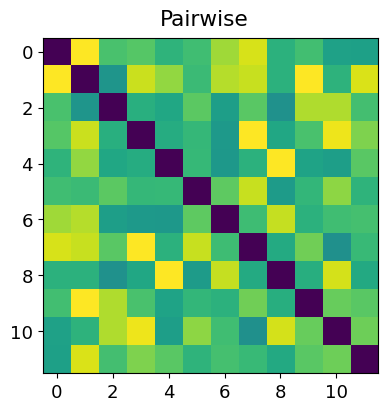

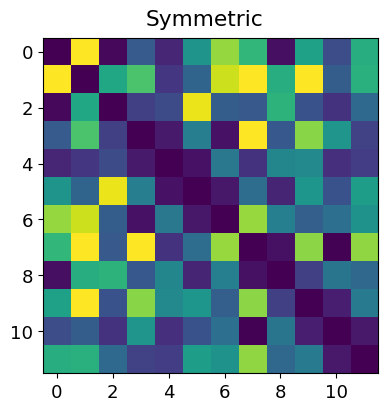

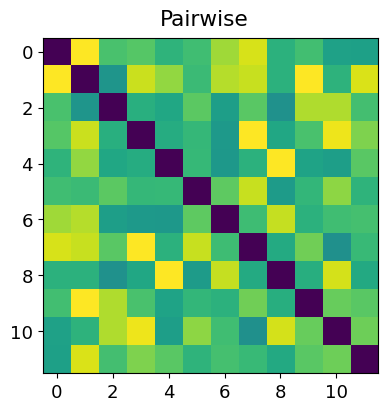

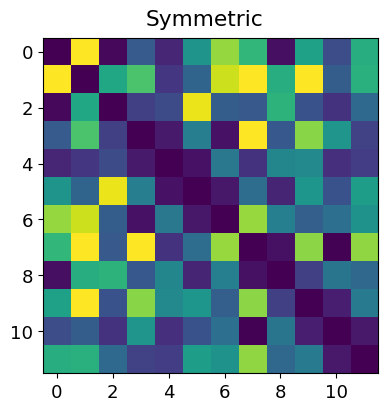

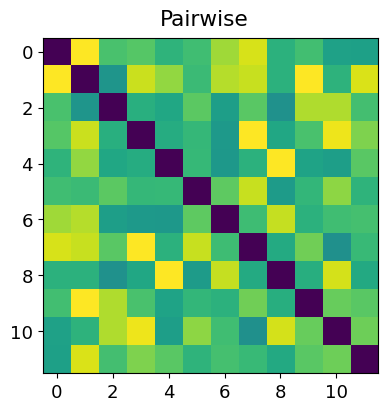

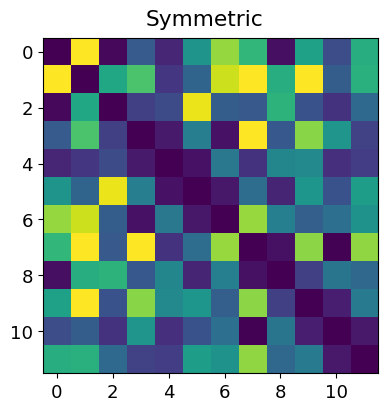

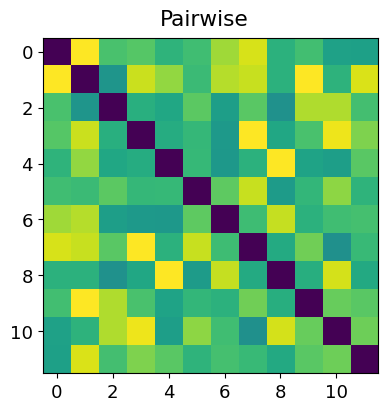

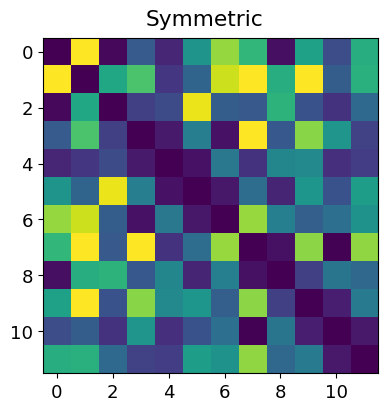

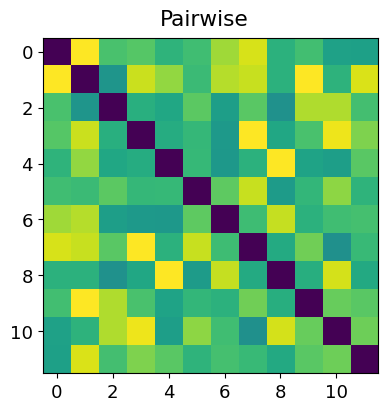

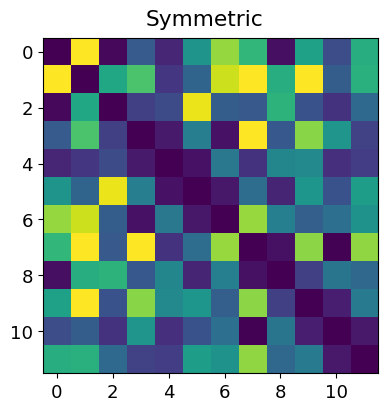

In [7]:
# CLBP with WSP
sub_con_CP_WSP = {}
for sub_id in sub_ids_CP_WSP:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Chronic Pain",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_CP_WSP[sub_id] = sub_avg_cons


utils.clear_display()

In [ ]:
# CLBP without WSP
sub_con_CP_No_WSP = {}
for sub_id in sub_ids_CP_No_WSP:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Chronic Pain wo WSP",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_CP_No_WSP[sub_id] = sub_avg_cons
utils.clear_display()

In [ ]:
# Healthy Control group
sub_con_HC = {}
for sub_id in sub_ids_HC:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Healthy Control",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_HC[sub_id] = sub_avg_cons
utils.clear_display()

In [ ]:
# Stack the connectivity of all subjects in each group
group_con_CP_WSP = fc.compute_group_con(sub_con_CP_WSP, conditions, con_methods, band_names)
group_con_CP_No_WSP = fc.compute_group_con(sub_con_CP_No_WSP, conditions, con_methods, band_names)
group_con_HC = fc.compute_group_con(sub_con_HC, conditions, con_methods, band_names)

In [ ]:
save_flag = True

if save_flag:
    # Save/checkpoint as pickle
    utils.pickle_data(save_path, f"sub_con_{subset}_CP_WSP.pkl", sub_con_CP_WSP)
    utils.pickle_data(save_path, f"sub_con_{subset}_CP_No_WSP.pkl", sub_con_CP_No_WSP)
    utils.pickle_data(save_path, f"sub_con_{subset}_HC.pkl", sub_con_HC)

    utils.pickle_data(save_path, f"group_con_{subset}_CP_WSP.pkl", group_con_CP_WSP)
    utils.pickle_data(save_path, f"group_con_{subset}_CP_No_WSP.pkl", group_con_CP_No_WSP)
    utils.pickle_data(save_path, f"group_con_{subset}_HC.pkl", group_con_HC)

### Plot and compute satistics to assess statistical differences 

In [ ]:
# Plot brain for AEC measure
plot_brain=True

In [ ]:
# CP Widespread Pain Hand HS. vs Healthy Control Hand HS
these_group_names = ["CP with Widespread Pain", "Healthy Control","Mann_Whitney_U_test"]
these_group_cons = [group_con_CP_WSP, group_con_HC]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_WSP_vs_HC_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        for band in band_names:
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
            group1_stack = these_group_cons[0][condition][method][band]
            group2_stack = these_group_cons[1][condition][method][band]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']

            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, group2_stack,roi_names,method=method)

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_acronyms,
                condition=condition,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=["CP with WSP vs. HC",
                        these_group_names[0], 
                        these_group_names[1],],
                save_names=["Chronic_Pain", 
                            "Healthy_Control", 
                            "Mann_Whitney_U_test"],
                save_path=stats_save_path,
                )           
            
            fc.plot_connectivity_and_stats(means_1,
                                           means_2,
                                           sem_1,
                                           sem_2,
                                           p_values,
                                           **plot_kwargs,
                                           save_fig=True,
            )
            
            if "aec" in method and plot_brain:
                # Convert ROI names to labels
                labels = [
                    mne.read_labels_from_annot(
                        subject, regexp=roi, subjects_dir=subjects_dir
                    )[0]
                    for roi in roi_names
                ]

                # Load the inverse
                inv = None
                if "Eyes" not in condition:
                    inv = utils.unpickle_data(
                        zscored_epochs_data_path / f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Open":
                    inv = utils.unpickle_data(
                        EO_resting_data_path / f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Closed":
                    inv = utils.unpickle_data(
                        EC_resting_data_path / f"{sub_id}_inv.pkl"
                    )

                fc.plot_degree(
                    p_values, 
                    title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_1, 
                    title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_2, 
                    title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )

            # fc.plot_connectivity_circle(con_data, **plot_kwargs, save_path=save_path)

In [ ]:
# CP Widespread Pain Hand HS. vs CP without Widespread Pain
these_group_names = ["CP with Widespread Pain", "CP without Widespread Pain"]
these_group_cons = [group_con_CP_WSP, group_con_CP_No_WSP]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_WSP_vs_CP_No_WSP_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        for band in band_names:
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
            group1_stack = these_group_cons[0][condition][method][band]
            group2_stack = these_group_cons[1][condition][method][band]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            
            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, group2_stack,roi_names,method=method)

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_acronyms,
                condition=condition,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=["CP w/ WSP vs. CP w/o WSP",
                        these_group_names[0], 
                        these_group_names[1], ],
                save_names=[these_group_names[0], 
                            these_group_names[1],
                            "Mann_Whitney_U_test"],
                save_path=stats_save_path,
                )           
            
            fc.plot_connectivity_and_stats(means_1,
                                           means_2,
                                           sem_1,
                                           sem_2,
                                           p_values,
                                           **plot_kwargs,
                                           save_fig=True,
            )
            
            # fc.plot_connectivity_circle(con_data, **plot_kwargs, save_path=save_path)